In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 1e-4

ENCODER_1 = 512
ENCODER_2 = 128
ENCODER_3 = 64

LATENT_VECTOR = 32

DECODER_1 = 64
DECODER_2 = 128
DECODER_3 = 512

# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

view_data = training_data.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# 학습 데이터를 학습/검증 데이터로 분리합니다.
training_data, validation_data = train_test_split(training_data, test_size=10000)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8607078.68it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136214.51it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2515340.46it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15830115.10it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# 데이터의 형태를 확인합니다.
for X, y in test_dataloader:
    input_shape = X.shape[2] * X.shape[3]
    print(f"Shape of input: {input_shape}")
    num_class = len(y.unique())
    print(f"num of class: {num_class}")
    break

Shape of input: 784
num of class: 10


In [5]:
# AutoEncoder 모델을 정의합니다.
class Autoencoder(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape,ENCODER_1),
            nn.GELU(),
            nn.BatchNorm1d(ENCODER_1),
            nn.Dropout(p=dropout_rate),
            nn.Linear(ENCODER_1, ENCODER_2),
            nn.GELU(),
            nn.BatchNorm1d(ENCODER_2),
            nn.Dropout(p=dropout_rate),
            nn.Linear(ENCODER_2, ENCODER_3),
            nn.GELU(),
            nn.BatchNorm1d(ENCODER_3),
            nn.Dropout(p=dropout_rate),
            nn.Linear(ENCODER_3, LATENT_VECTOR)
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_VECTOR, DECODER_1),
            nn.GELU(),
            nn.BatchNorm1d(DECODER_1),
            nn.Linear(DECODER_1, DECODER_2),
            nn.GELU(),
            nn.BatchNorm1d(DECODER_2),
            nn.Linear(DECODER_2, DECODER_3),
            nn.GELU(),
            nn.BatchNorm1d(DECODER_3),
            nn.Linear(DECODER_3, input_shape),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): GELU(approximate='none')
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linea

In [6]:
# 손실함수와 optimizer를 설정합니다.
#loss_fn = nn.MSELoss()
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
# train 함수를 정의합니다.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = X.view(-1,28*28).to(device)

        # 복원 오차값(=손실값)을 계산합니다.
        recon = model(X)
        loss = loss_fn(recon, X)

        # 손실값을 역전파하여 모델을 갱신합니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [8]:
# test 함수를 정의합니다.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X = X.view(-1,28*28).to(device)

            recon = model(X)
            loss = loss_fn(recon, X)
            test_loss += loss
    test_loss /= num_batches
    return test_loss

Epoch 1
-------------------------------


782it [00:16, 48.74it/s]


[Epoch 0]


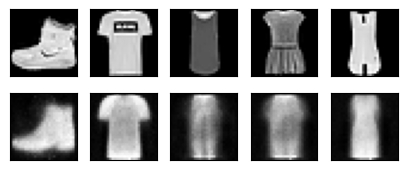

Train Error: 0.018818 

Validation Error: 0.018751 

Epoch 2
-------------------------------


782it [00:15, 51.22it/s]


[Epoch 1]


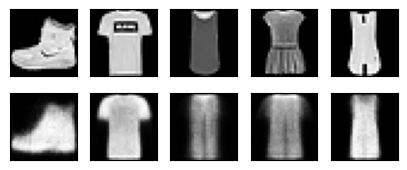

Train Error: 0.009546 

Validation Error: 0.009709 

Epoch 3
-------------------------------


782it [00:15, 51.46it/s]


[Epoch 2]


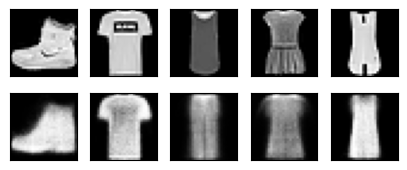

Train Error: 0.008293 

Validation Error: 0.008461 

Epoch 4
-------------------------------


782it [00:15, 50.44it/s]


[Epoch 3]


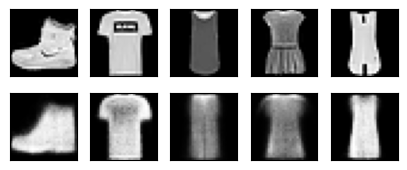

Train Error: 0.007473 

Validation Error: 0.007651 

Epoch 5
-------------------------------


782it [00:15, 50.65it/s]


[Epoch 4]


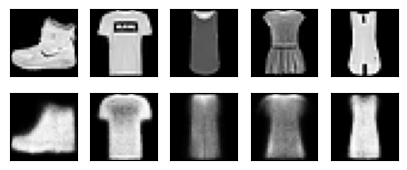

Train Error: 0.006897 

Validation Error: 0.007077 

Epoch 6
-------------------------------


782it [00:15, 49.17it/s]


[Epoch 5]


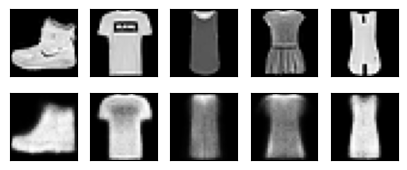

Train Error: 0.006488 

Validation Error: 0.006672 

Epoch 7
-------------------------------


782it [00:20, 38.90it/s]


[Epoch 6]


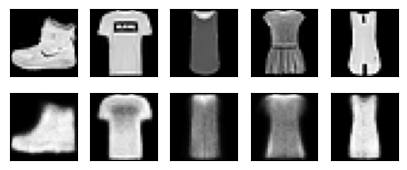

Train Error: 0.006162 

Validation Error: 0.006351 

Epoch 8
-------------------------------


782it [00:16, 48.27it/s]


[Epoch 7]


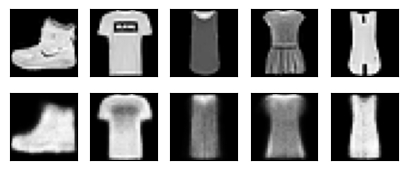

Train Error: 0.005905 

Validation Error: 0.006100 

Epoch 9
-------------------------------


782it [00:16, 48.78it/s]


[Epoch 8]


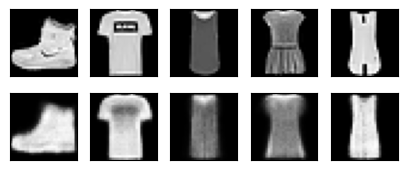

Train Error: 0.005695 

Validation Error: 0.005894 

Epoch 10
-------------------------------


782it [00:15, 48.92it/s]


[Epoch 9]


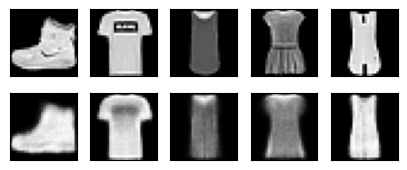

Train Error: 0.005520 

Validation Error: 0.005724 

Epoch 11
-------------------------------


782it [00:17, 45.64it/s]


[Epoch 10]


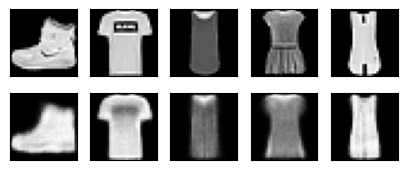

Train Error: 0.005365 

Validation Error: 0.005573 

Epoch 12
-------------------------------


782it [00:15, 49.08it/s]


[Epoch 11]


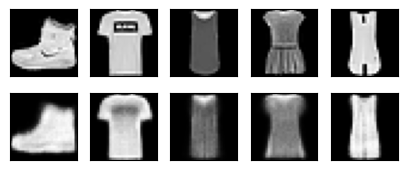

Train Error: 0.005225 

Validation Error: 0.005438 

Epoch 13
-------------------------------


782it [00:16, 48.69it/s]


[Epoch 12]


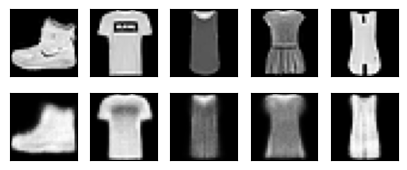

Train Error: 0.005105 

Validation Error: 0.005321 

Epoch 14
-------------------------------


782it [00:15, 50.26it/s]


[Epoch 13]


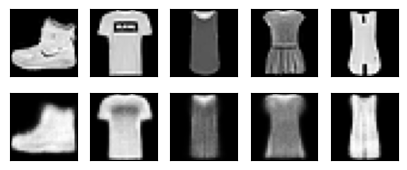

Train Error: 0.005002 

Validation Error: 0.005223 

Epoch 15
-------------------------------


782it [00:15, 49.33it/s]


[Epoch 14]


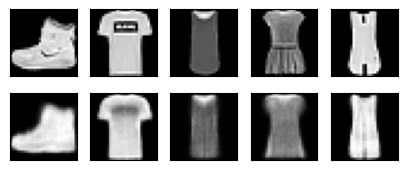

Train Error: 0.004912 

Validation Error: 0.005138 

Epoch 16
-------------------------------


782it [00:15, 48.91it/s]


[Epoch 15]


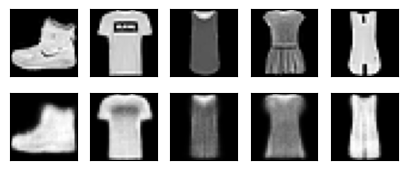

Train Error: 0.004830 

Validation Error: 0.005061 

Epoch 17
-------------------------------


782it [00:15, 50.84it/s]


[Epoch 16]


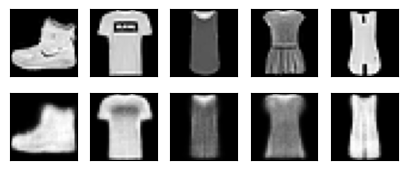

Train Error: 0.004754 

Validation Error: 0.004990 

Epoch 18
-------------------------------


782it [00:15, 49.59it/s]


[Epoch 17]


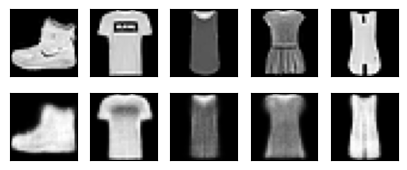

Train Error: 0.004683 

Validation Error: 0.004924 

Epoch 19
-------------------------------


782it [00:15, 49.62it/s]


[Epoch 18]


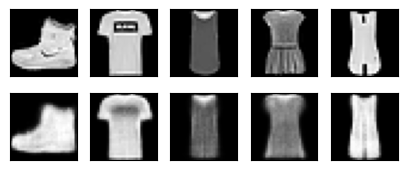

Train Error: 0.004618 

Validation Error: 0.004863 

Epoch 20
-------------------------------


782it [00:15, 49.89it/s]


[Epoch 19]


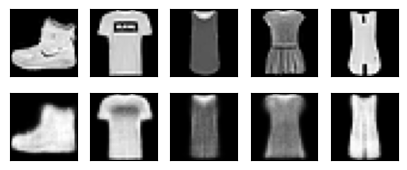

Train Error: 0.004558 

Validation Error: 0.004808 

Epoch 21
-------------------------------


782it [00:15, 49.63it/s]


[Epoch 20]


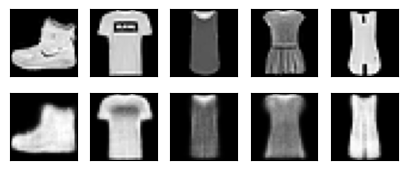

Train Error: 0.004504 

Validation Error: 0.004758 

Epoch 22
-------------------------------


782it [00:16, 48.72it/s]


[Epoch 21]


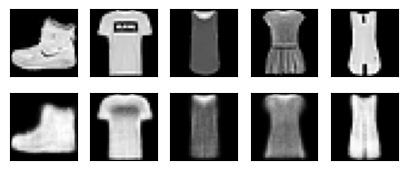

Train Error: 0.004454 

Validation Error: 0.004713 

Epoch 23
-------------------------------


782it [00:15, 49.49it/s]


[Epoch 22]


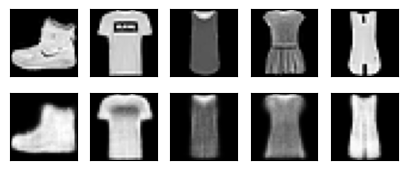

Train Error: 0.004409 

Validation Error: 0.004673 

Epoch 24
-------------------------------


782it [00:15, 49.14it/s]


[Epoch 23]


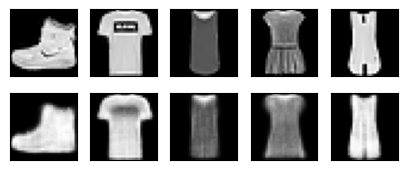

Train Error: 0.004368 

Validation Error: 0.004636 

Epoch 25
-------------------------------


782it [00:15, 49.69it/s]


[Epoch 24]


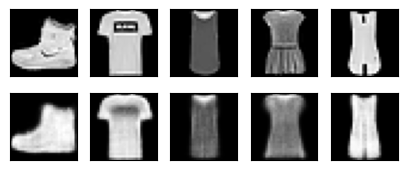

Train Error: 0.004328 

Validation Error: 0.004600 

Epoch 26
-------------------------------


782it [00:15, 50.28it/s]


[Epoch 25]


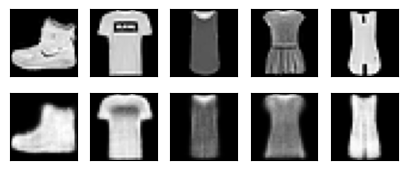

Train Error: 0.004289 

Validation Error: 0.004565 

Epoch 27
-------------------------------


782it [00:15, 50.15it/s]


[Epoch 26]


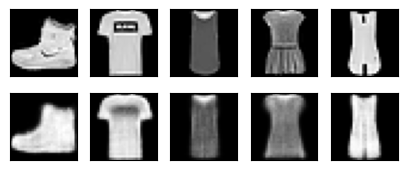

Train Error: 0.004250 

Validation Error: 0.004530 

Epoch 28
-------------------------------


782it [00:15, 49.31it/s]


[Epoch 27]


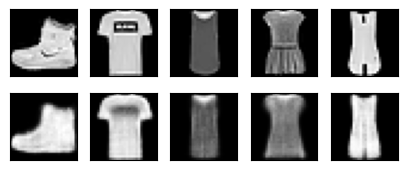

Train Error: 0.004213 

Validation Error: 0.004497 

Epoch 29
-------------------------------


782it [00:15, 50.77it/s]


[Epoch 28]


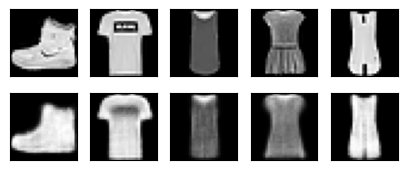

Train Error: 0.004177 

Validation Error: 0.004464 

Epoch 30
-------------------------------


782it [00:15, 48.93it/s]


[Epoch 29]


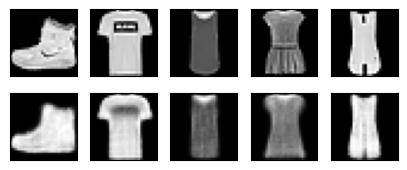

Train Error: 0.004144 

Validation Error: 0.004434 

Epoch 31
-------------------------------


782it [00:15, 50.77it/s]


[Epoch 30]


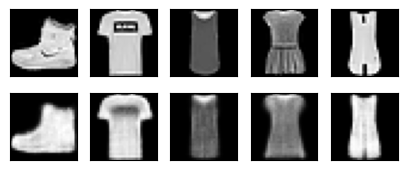

Train Error: 0.004111 

Validation Error: 0.004406 

Epoch 32
-------------------------------


782it [00:15, 49.45it/s]


[Epoch 31]


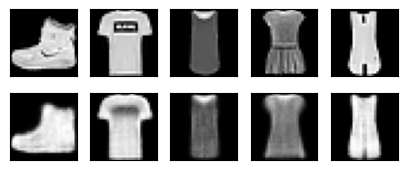

Train Error: 0.004082 

Validation Error: 0.004380 

Epoch 33
-------------------------------


782it [00:16, 47.45it/s]


[Epoch 32]


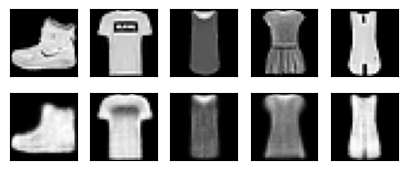

Train Error: 0.004053 

Validation Error: 0.004354 

Epoch 34
-------------------------------


782it [00:16, 47.81it/s]


[Epoch 33]


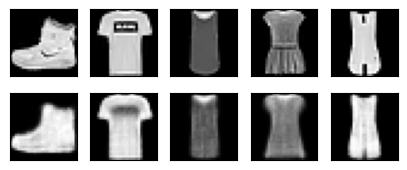

Train Error: 0.004026 

Validation Error: 0.004331 

Epoch 35
-------------------------------


782it [00:16, 48.17it/s]


[Epoch 34]


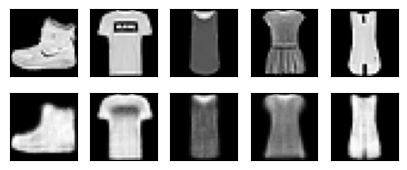

Train Error: 0.003999 

Validation Error: 0.004306 

Epoch 36
-------------------------------


782it [00:16, 47.75it/s]


[Epoch 35]


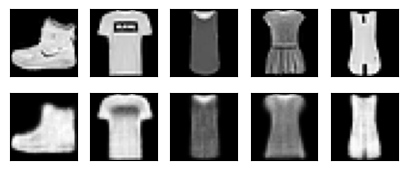

Train Error: 0.003973 

Validation Error: 0.004284 

Epoch 37
-------------------------------


782it [00:16, 48.59it/s]


[Epoch 36]


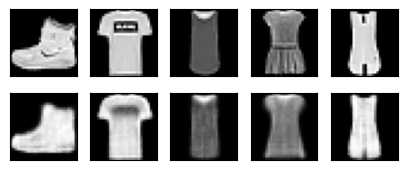

Train Error: 0.003947 

Validation Error: 0.004261 

Epoch 38
-------------------------------


782it [00:15, 49.42it/s]


[Epoch 37]


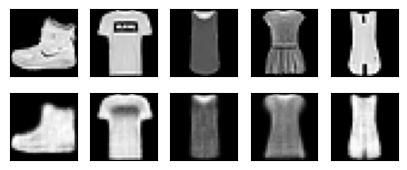

Train Error: 0.003922 

Validation Error: 0.004239 

Epoch 39
-------------------------------


782it [00:15, 48.88it/s]


[Epoch 38]


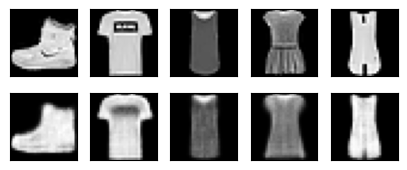

Train Error: 0.003898 

Validation Error: 0.004219 

Epoch 40
-------------------------------


782it [00:15, 50.06it/s]


[Epoch 39]


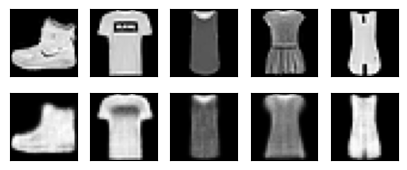

Train Error: 0.003877 

Validation Error: 0.004201 

Epoch 41
-------------------------------


782it [00:16, 48.34it/s]


[Epoch 40]


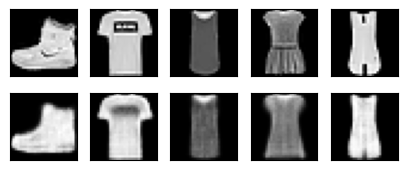

Train Error: 0.003863 

Validation Error: 0.004191 

Epoch 42
-------------------------------


782it [00:15, 49.86it/s]


[Epoch 41]


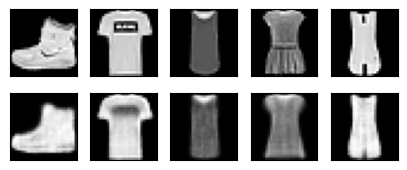

Train Error: 0.003827 

Validation Error: 0.004158 

Epoch 43
-------------------------------


782it [00:15, 49.01it/s]


[Epoch 42]


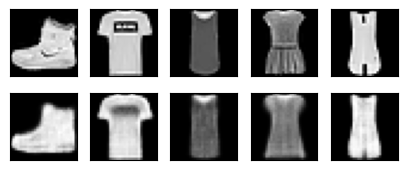

Train Error: 0.003805 

Validation Error: 0.004139 

Epoch 44
-------------------------------


782it [00:15, 49.09it/s]


[Epoch 43]


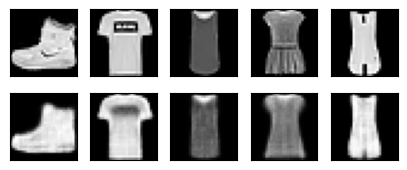

Train Error: 0.003785 

Validation Error: 0.004122 

Epoch 45
-------------------------------


782it [00:15, 49.28it/s]


[Epoch 44]


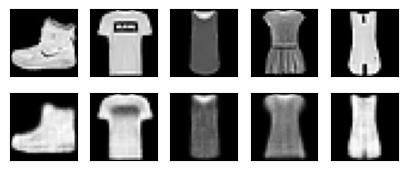

Train Error: 0.003766 

Validation Error: 0.004106 

Epoch 46
-------------------------------


782it [00:16, 48.67it/s]


[Epoch 45]


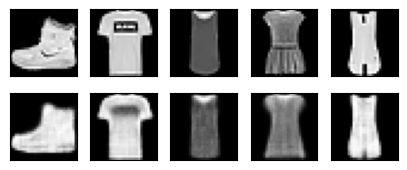

Train Error: 0.003745 

Validation Error: 0.004088 

Epoch 47
-------------------------------


782it [00:16, 47.94it/s]


[Epoch 46]


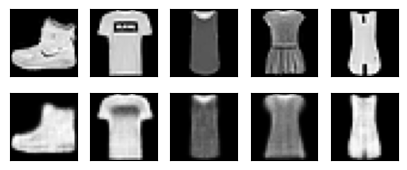

Train Error: 0.003728 

Validation Error: 0.004075 

Epoch 48
-------------------------------


782it [00:16, 48.53it/s]


[Epoch 47]


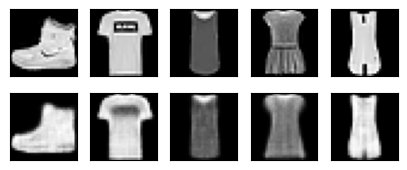

Train Error: 0.003713 

Validation Error: 0.004062 

Epoch 49
-------------------------------


782it [00:16, 47.28it/s]


[Epoch 48]


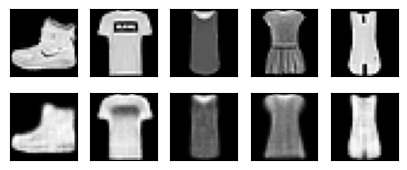

Train Error: 0.003699 

Validation Error: 0.004051 

Epoch 50
-------------------------------


782it [00:16, 47.78it/s]


[Epoch 49]


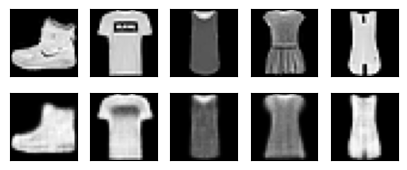

Train Error: 0.003686 

Validation Error: 0.004041 

Epoch 51
-------------------------------


782it [00:15, 49.43it/s]


[Epoch 50]


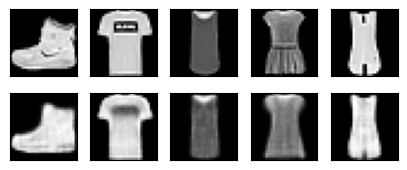

Train Error: 0.003674 

Validation Error: 0.004032 

Epoch 52
-------------------------------


782it [00:15, 48.99it/s]


[Epoch 51]


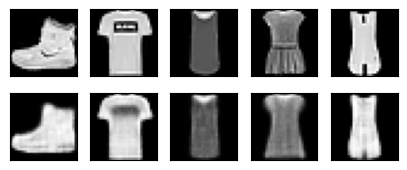

Train Error: 0.003661 

Validation Error: 0.004022 

Epoch 53
-------------------------------


782it [00:16, 48.22it/s]


[Epoch 52]


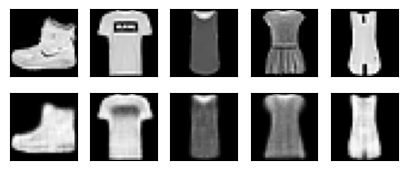

Train Error: 0.003649 

Validation Error: 0.004013 

Epoch 54
-------------------------------


782it [00:16, 47.59it/s]


[Epoch 53]


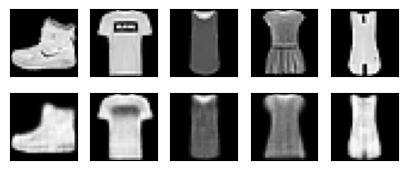

Train Error: 0.003636 

Validation Error: 0.004004 

Epoch 55
-------------------------------


782it [00:16, 46.58it/s]


[Epoch 54]


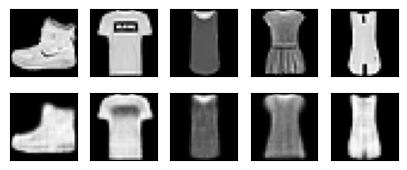

Train Error: 0.003627 

Validation Error: 0.003998 

Epoch 56
-------------------------------


782it [00:16, 47.19it/s]


[Epoch 55]


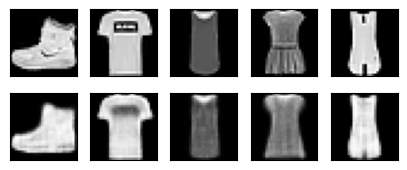

Train Error: 0.003619 

Validation Error: 0.003993 

Epoch 57
-------------------------------


782it [00:16, 48.49it/s]


[Epoch 56]


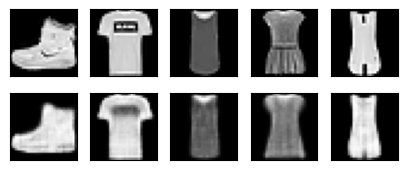

Train Error: 0.003603 

Validation Error: 0.003979 

Epoch 58
-------------------------------


782it [00:16, 48.44it/s]


[Epoch 57]


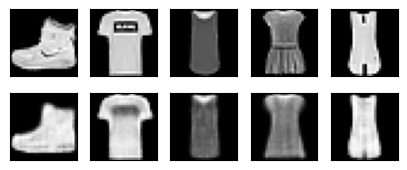

Train Error: 0.003600 

Validation Error: 0.003978 

Epoch 59
-------------------------------


782it [00:16, 47.19it/s]


[Epoch 58]


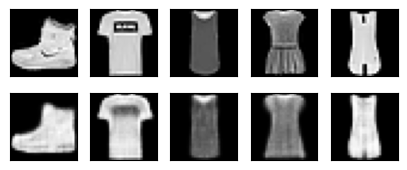

Train Error: 0.003593 

Validation Error: 0.003974 

Epoch 60
-------------------------------


782it [00:16, 47.35it/s]


[Epoch 59]


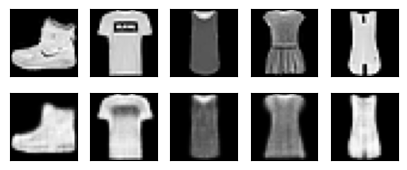

Train Error: 0.003582 

Validation Error: 0.003966 

Epoch 61
-------------------------------


782it [00:16, 47.03it/s]


[Epoch 60]


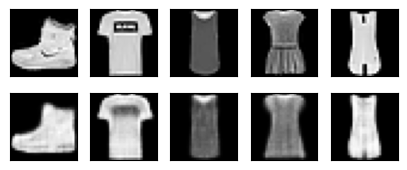

Train Error: 0.003567 

Validation Error: 0.003953 

Epoch 62
-------------------------------


782it [00:16, 46.64it/s]


[Epoch 61]


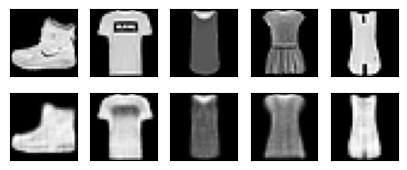

Train Error: 0.003550 

Validation Error: 0.003940 

Epoch 63
-------------------------------


782it [00:16, 46.04it/s]


[Epoch 62]


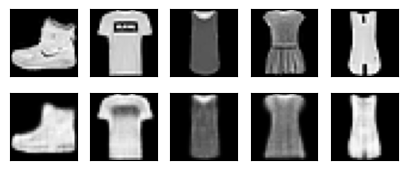

Train Error: 0.003537 

Validation Error: 0.003929 

Epoch 64
-------------------------------


782it [00:17, 45.56it/s]


[Epoch 63]


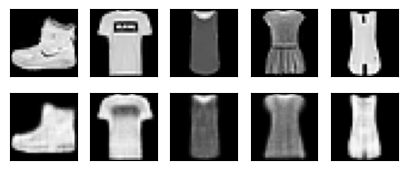

Train Error: 0.003527 

Validation Error: 0.003922 

Epoch 65
-------------------------------


782it [00:16, 46.98it/s]


[Epoch 64]


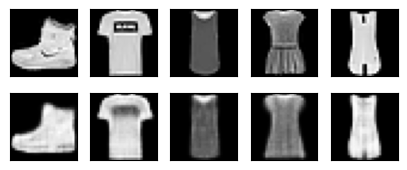

Train Error: 0.003519 

Validation Error: 0.003917 

Epoch 66
-------------------------------


782it [00:16, 46.84it/s]


[Epoch 65]


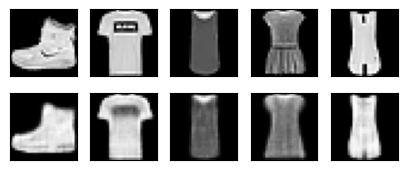

Train Error: 0.003510 

Validation Error: 0.003911 

Epoch 67
-------------------------------


782it [00:16, 46.01it/s]


[Epoch 66]


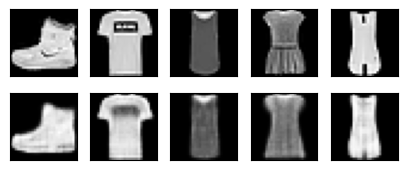

Train Error: 0.003504 

Validation Error: 0.003908 

Epoch 68
-------------------------------


782it [00:16, 46.04it/s]


[Epoch 67]


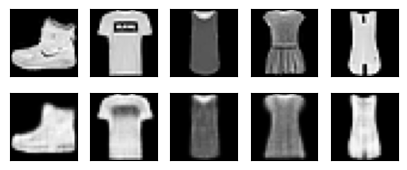

Train Error: 0.003497 

Validation Error: 0.003903 

Epoch 69
-------------------------------


782it [00:17, 45.43it/s]


[Epoch 68]


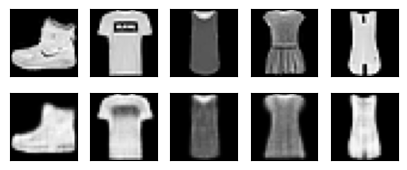

Train Error: 0.003492 

Validation Error: 0.003901 

Epoch 70
-------------------------------


782it [00:16, 46.38it/s]


[Epoch 69]


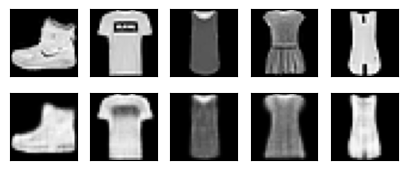

Train Error: 0.003486 

Validation Error: 0.003898 

Epoch 71
-------------------------------


782it [00:16, 46.17it/s]


[Epoch 70]


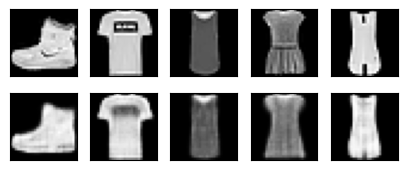

Train Error: 0.003487 

Validation Error: 0.003902 

Epoch 72
-------------------------------


782it [00:17, 45.59it/s]


[Epoch 71]


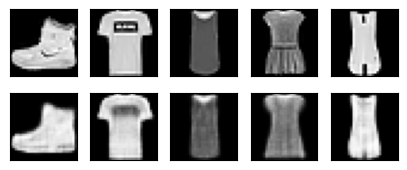

Train Error: 0.003482 

Validation Error: 0.003900 

Epoch 73
-------------------------------


782it [00:17, 45.82it/s]


[Epoch 72]


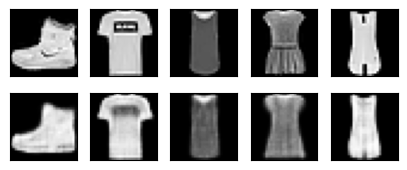

Train Error: 0.003480 

Validation Error: 0.003899 

Epoch 74
-------------------------------


782it [00:16, 46.32it/s]


[Epoch 73]


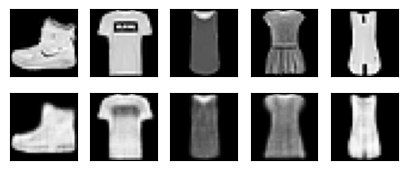

Train Error: 0.003492 

Validation Error: 0.003912 

Epoch 75
-------------------------------


782it [00:17, 44.79it/s]


[Epoch 74]


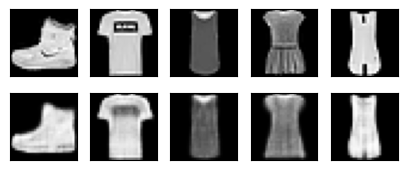

Train Error: 0.003495 

Validation Error: 0.003918 

Epoch 76
-------------------------------


782it [00:18, 43.15it/s]


[Epoch 75]


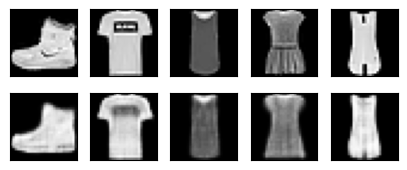

Train Error: 0.003485 

Validation Error: 0.003910 

Epoch 77
-------------------------------


782it [00:18, 42.65it/s]


[Epoch 76]


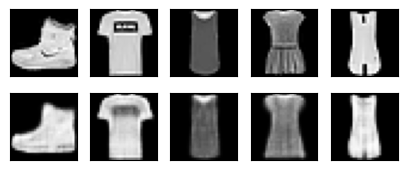

Train Error: 0.003466 

Validation Error: 0.003894 

Epoch 78
-------------------------------


782it [00:17, 43.58it/s]


[Epoch 77]


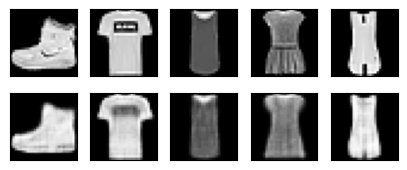

Train Error: 0.003446 

Validation Error: 0.003877 

Epoch 79
-------------------------------


782it [00:17, 43.58it/s]


[Epoch 78]


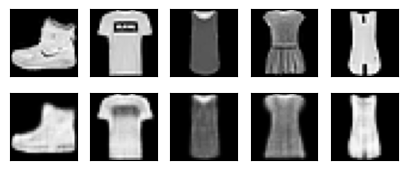

Train Error: 0.003427 

Validation Error: 0.003862 

Epoch 80
-------------------------------


782it [00:18, 42.66it/s]


[Epoch 79]


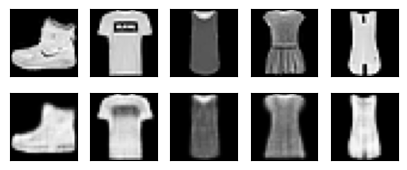

Train Error: 0.003415 

Validation Error: 0.003852 

Epoch 81
-------------------------------


782it [00:18, 42.62it/s]


[Epoch 80]


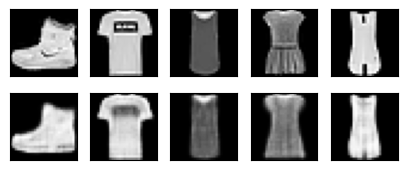

Train Error: 0.003407 

Validation Error: 0.003847 

Epoch 82
-------------------------------


782it [00:18, 42.56it/s]


[Epoch 81]


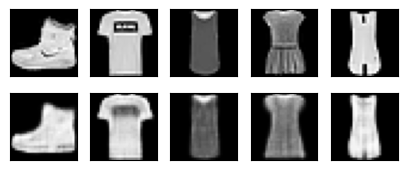

Train Error: 0.003399 

Validation Error: 0.003841 

Epoch 83
-------------------------------


782it [00:18, 42.51it/s]


[Epoch 82]


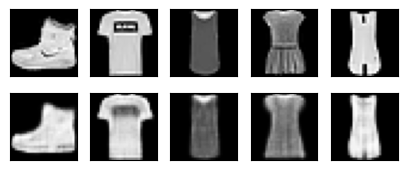

Train Error: 0.003394 

Validation Error: 0.003839 

Epoch 84
-------------------------------


782it [00:18, 42.59it/s]


[Epoch 83]


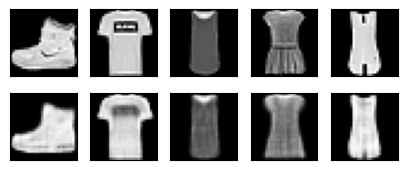

Train Error: 0.003389 

Validation Error: 0.003836 

Epoch 85
-------------------------------


782it [00:18, 42.02it/s]


[Epoch 84]


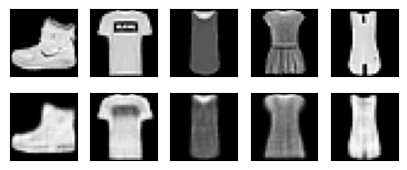

Train Error: 0.003386 

Validation Error: 0.003836 

Epoch 86
-------------------------------


782it [00:18, 42.10it/s]


[Epoch 85]


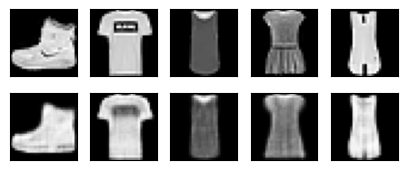

Train Error: 0.003384 

Validation Error: 0.003837 

Epoch 87
-------------------------------


782it [00:18, 42.38it/s]


[Epoch 86]


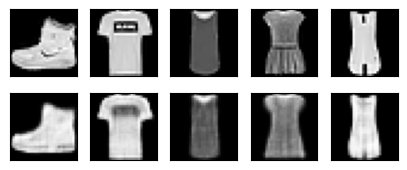

Train Error: 0.003390 

Validation Error: 0.003845 

Epoch 88
-------------------------------


782it [00:19, 40.80it/s]


[Epoch 87]


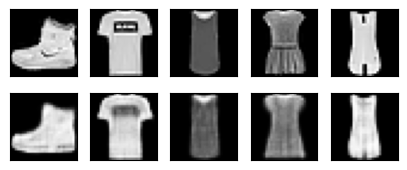

Train Error: 0.003391 

Validation Error: 0.003848 

Epoch 89
-------------------------------


782it [00:18, 42.42it/s]


[Epoch 88]


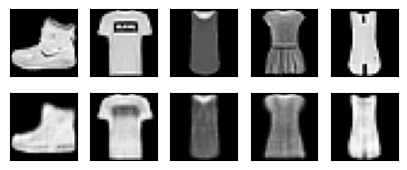

Train Error: 0.003389 

Validation Error: 0.003847 

Epoch 90
-------------------------------


782it [00:18, 41.90it/s]


[Epoch 89]


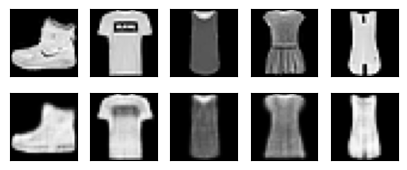

Train Error: 0.003405 

Validation Error: 0.003864 

Epoch 91
-------------------------------


782it [00:19, 40.94it/s]


[Epoch 90]


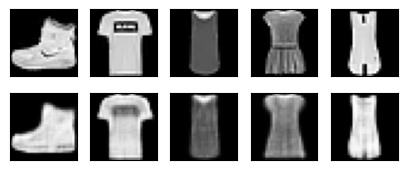

Train Error: 0.003418 

Validation Error: 0.003879 

Epoch 92
-------------------------------


782it [00:18, 41.91it/s]


[Epoch 91]


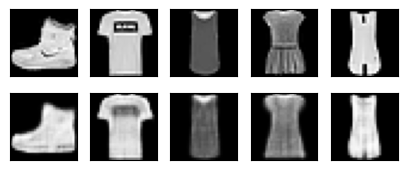

Train Error: 0.003406 

Validation Error: 0.003870 

Epoch 93
-------------------------------


782it [00:19, 41.10it/s]


[Epoch 92]


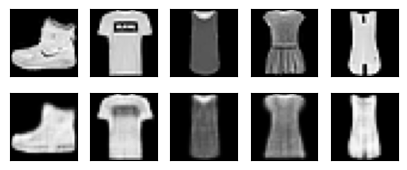

Train Error: 0.003392 

Validation Error: 0.003858 

Epoch 94
-------------------------------


782it [00:18, 41.47it/s]


[Epoch 93]


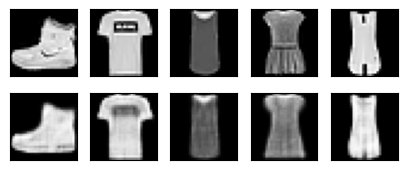

Train Error: 0.003378 

Validation Error: 0.003847 

Epoch 95
-------------------------------


782it [00:19, 41.05it/s]


[Epoch 94]


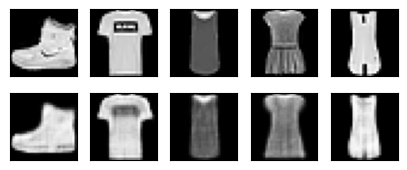

Train Error: 0.003355 

Validation Error: 0.003827 

Epoch 96
-------------------------------


782it [00:18, 41.81it/s]


[Epoch 95]


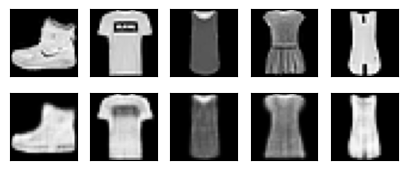

Train Error: 0.003339 

Validation Error: 0.003814 

Epoch 97
-------------------------------


782it [00:19, 41.08it/s]


[Epoch 96]


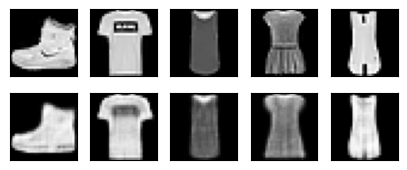

Train Error: 0.003332 

Validation Error: 0.003809 

Epoch 98
-------------------------------


782it [00:19, 41.15it/s]


[Epoch 97]


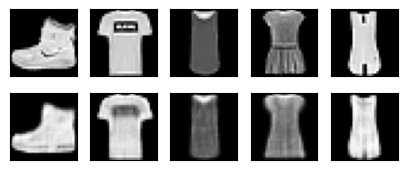

Train Error: 0.003323 

Validation Error: 0.003802 

Epoch 99
-------------------------------


782it [00:19, 40.75it/s]


[Epoch 98]


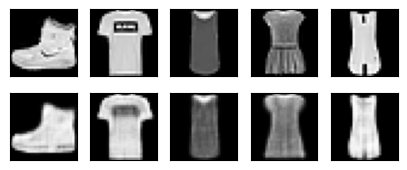

Train Error: 0.003319 

Validation Error: 0.003801 

Epoch 100
-------------------------------


782it [00:19, 40.66it/s]


[Epoch 99]


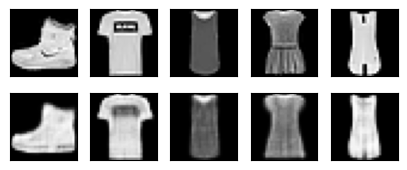

Train Error: 0.003313 

Validation Error: 0.003798 

Epoch 101
-------------------------------


782it [00:19, 41.08it/s]


[Epoch 100]


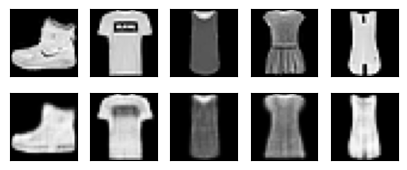

Train Error: 0.003312 

Validation Error: 0.003798 

Epoch 102
-------------------------------


782it [00:19, 40.38it/s]


[Epoch 101]


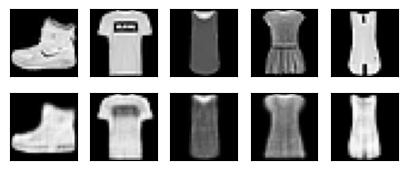

Train Error: 0.003310 

Validation Error: 0.003799 

Epoch 103
-------------------------------


782it [00:19, 40.06it/s]


[Epoch 102]


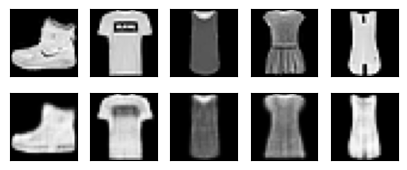

Train Error: 0.003312 

Validation Error: 0.003804 

Epoch 104
-------------------------------


782it [00:19, 40.44it/s]


[Epoch 103]


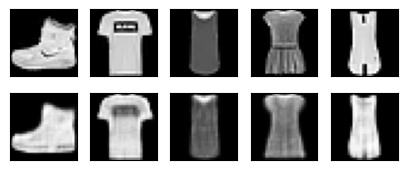

Train Error: 0.003317 

Validation Error: 0.003809 

Epoch 105
-------------------------------


782it [00:19, 40.35it/s]


[Epoch 104]


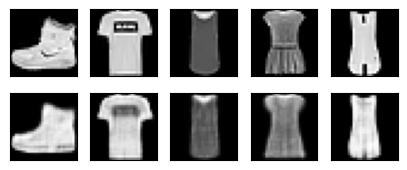

Train Error: 0.003314 

Validation Error: 0.003808 

Epoch 106
-------------------------------


782it [00:19, 39.41it/s]


[Epoch 105]


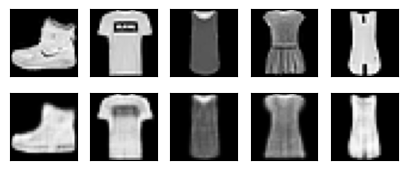

Train Error: 0.003326 

Validation Error: 0.003821 

Epoch 107
-------------------------------


782it [00:19, 39.97it/s]


[Epoch 106]


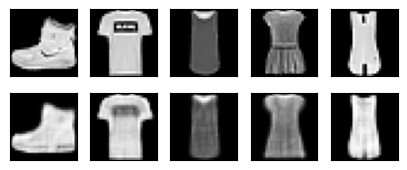

Train Error: 0.003355 

Validation Error: 0.003853 

Epoch 108
-------------------------------


782it [00:20, 39.00it/s]


[Epoch 107]


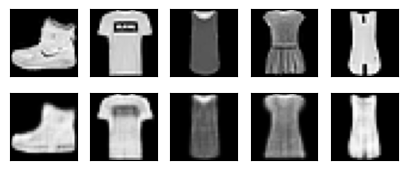

Train Error: 0.003337 

Validation Error: 0.003837 

Epoch 109
-------------------------------


782it [00:19, 39.72it/s]


[Epoch 108]


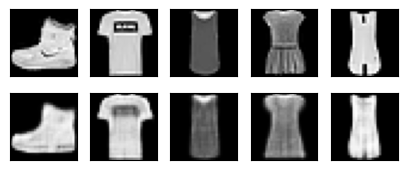

Train Error: 0.003326 

Validation Error: 0.003828 

Epoch 110
-------------------------------


782it [00:19, 40.17it/s]


[Epoch 109]


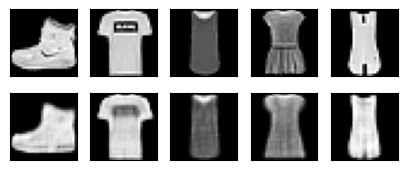

Train Error: 0.003312 

Validation Error: 0.003816 

Epoch 111
-------------------------------


782it [00:19, 40.57it/s]


[Epoch 110]


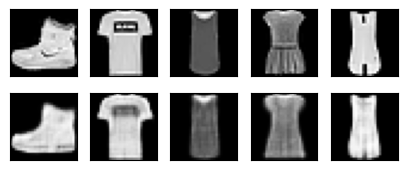

Train Error: 0.003305 

Validation Error: 0.003812 

Epoch 112
-------------------------------


782it [00:19, 39.56it/s]


[Epoch 111]


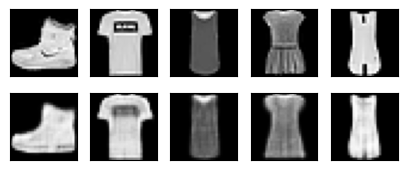

Train Error: 0.003283 

Validation Error: 0.003792 

Epoch 113
-------------------------------


782it [00:19, 40.14it/s]


[Epoch 112]


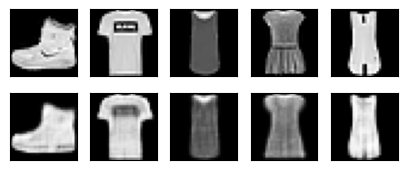

Train Error: 0.003282 

Validation Error: 0.003793 

Epoch 114
-------------------------------


782it [00:19, 39.58it/s]


[Epoch 113]


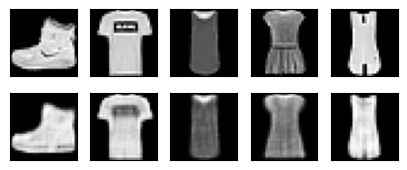

Train Error: 0.003266 

Validation Error: 0.003780 

Epoch 115
-------------------------------


782it [00:19, 39.83it/s]


[Epoch 114]


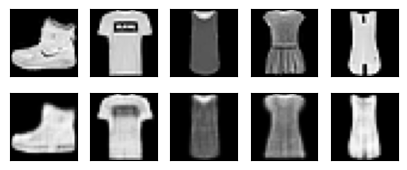

Train Error: 0.003268 

Validation Error: 0.003784 

Epoch 116
-------------------------------


782it [00:19, 39.99it/s]


[Epoch 115]


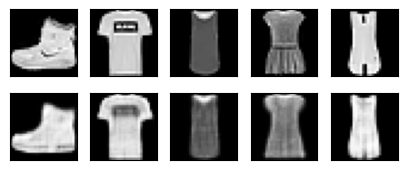

Train Error: 0.003260 

Validation Error: 0.003778 

Epoch 117
-------------------------------


782it [00:19, 39.61it/s]


[Epoch 116]


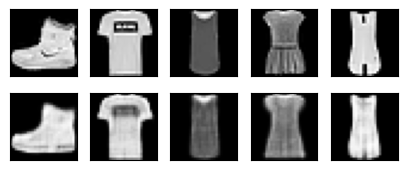

Train Error: 0.003262 

Validation Error: 0.003781 

Epoch 118
-------------------------------


782it [00:19, 40.34it/s]


[Epoch 117]


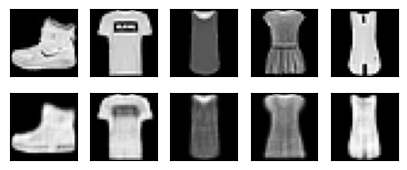

Train Error: 0.003253 

Validation Error: 0.003775 

Epoch 119
-------------------------------


782it [00:20, 38.99it/s]


[Epoch 118]


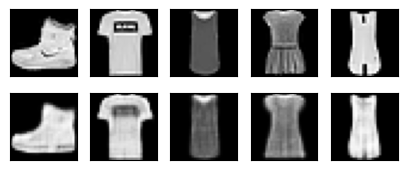

Train Error: 0.003258 

Validation Error: 0.003781 

Epoch 120
-------------------------------


782it [00:19, 40.51it/s]


[Epoch 119]


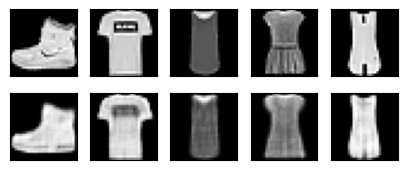

Train Error: 0.003252 

Validation Error: 0.003778 

Epoch 121
-------------------------------


782it [00:19, 39.44it/s]


[Epoch 120]


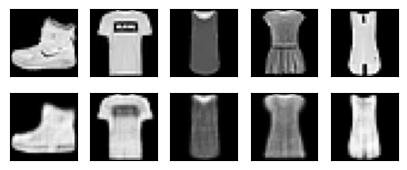

Train Error: 0.003261 

Validation Error: 0.003787 

Epoch 122
-------------------------------


782it [00:19, 39.42it/s]


[Epoch 121]


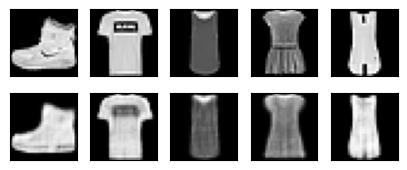

Train Error: 0.003260 

Validation Error: 0.003789 

Epoch 123
-------------------------------


782it [00:19, 39.60it/s]


[Epoch 122]


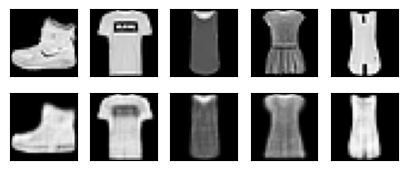

Train Error: 0.003275 

Validation Error: 0.003805 

Epoch 124
-------------------------------


782it [00:20, 38.83it/s]


[Epoch 123]


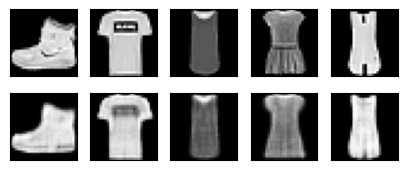

Train Error: 0.003286 

Validation Error: 0.003819 

Epoch 125
-------------------------------


782it [00:20, 38.72it/s]


[Epoch 124]


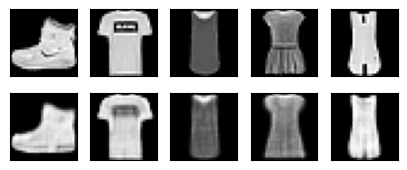

Train Error: 0.003278 

Validation Error: 0.003811 

Epoch 126
-------------------------------


782it [00:20, 39.01it/s]


[Epoch 125]


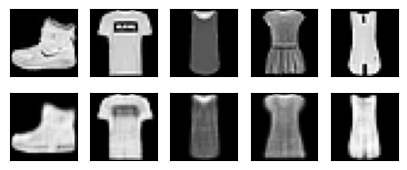

Train Error: 0.003253 

Validation Error: 0.003788 

Epoch 127
-------------------------------


782it [00:19, 40.04it/s]


[Epoch 126]


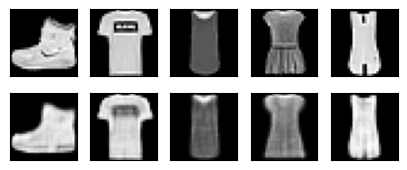

Train Error: 0.003245 

Validation Error: 0.003783 

Epoch 128
-------------------------------


782it [00:20, 38.42it/s]


[Epoch 127]


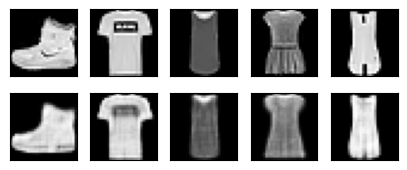

Train Error: 0.003238 

Validation Error: 0.003778 

Epoch 129
-------------------------------


782it [00:19, 39.18it/s]


[Epoch 128]


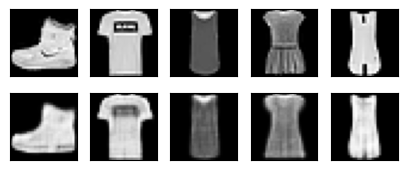

Train Error: 0.003230 

Validation Error: 0.003772 

Epoch 130
-------------------------------


782it [00:20, 37.79it/s]


[Epoch 129]


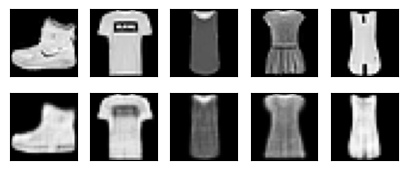

Train Error: 0.003219 

Validation Error: 0.003764 

Epoch 131
-------------------------------


782it [00:19, 39.93it/s]


[Epoch 130]


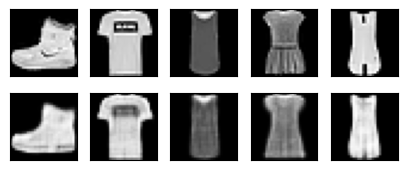

Train Error: 0.003226 

Validation Error: 0.003772 

Epoch 132
-------------------------------


782it [00:20, 38.87it/s]


[Epoch 131]


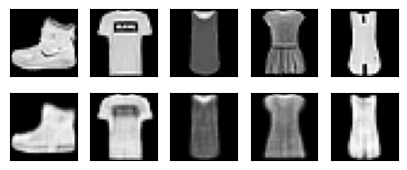

Train Error: 0.003210 

Validation Error: 0.003758 

Epoch 133
-------------------------------


782it [00:19, 40.16it/s]


[Epoch 132]


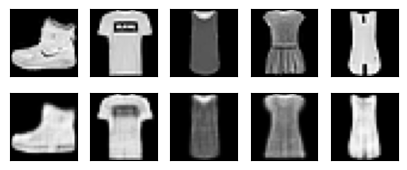

Train Error: 0.003222 

Validation Error: 0.003772 

Epoch 134
-------------------------------


782it [00:20, 39.09it/s]


[Epoch 133]


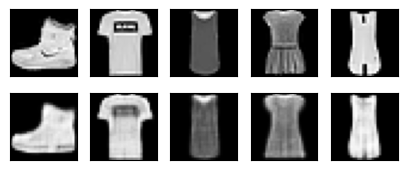

Train Error: 0.003209 

Validation Error: 0.003761 

Epoch 135
-------------------------------


782it [00:19, 39.54it/s]


[Epoch 134]


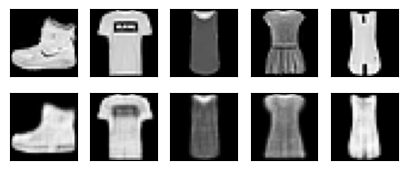

Train Error: 0.003210 

Validation Error: 0.003764 

Epoch 136
-------------------------------


782it [00:20, 38.99it/s]


[Epoch 135]


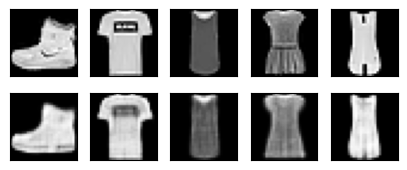

Train Error: 0.003206 

Validation Error: 0.003762 

Epoch 137
-------------------------------


782it [00:20, 38.62it/s]


[Epoch 136]


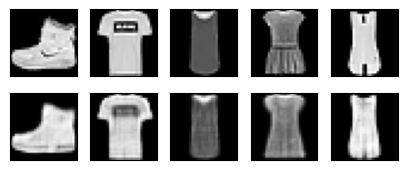

Train Error: 0.003208 

Validation Error: 0.003766 

Epoch 138
-------------------------------


782it [00:19, 39.93it/s]


[Epoch 137]


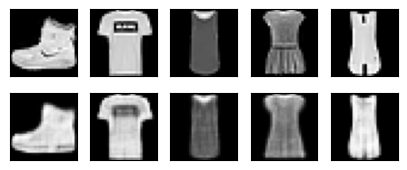

Train Error: 0.003196 

Validation Error: 0.003756 

Epoch 139
-------------------------------


782it [00:19, 39.47it/s]


[Epoch 138]


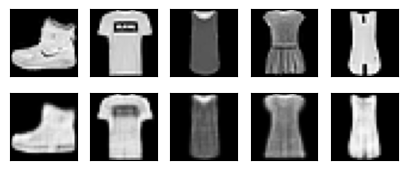

Train Error: 0.003231 

Validation Error: 0.003792 

Epoch 140
-------------------------------


782it [00:20, 38.24it/s]


[Epoch 139]


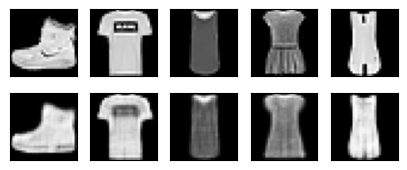

Train Error: 0.003205 

Validation Error: 0.003768 

Epoch 141
-------------------------------


782it [00:20, 38.90it/s]


[Epoch 140]


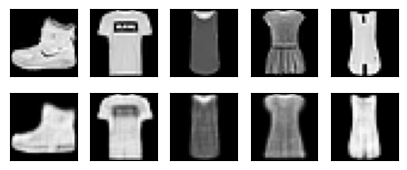

Train Error: 0.003228 

Validation Error: 0.003793 

Epoch 142
-------------------------------


782it [00:20, 37.43it/s]


[Epoch 141]


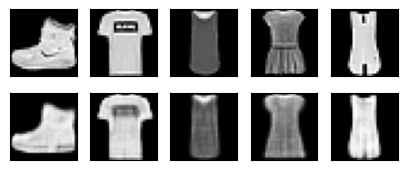

Train Error: 0.003226 

Validation Error: 0.003793 

Epoch 143
-------------------------------


782it [00:20, 38.94it/s]


[Epoch 142]


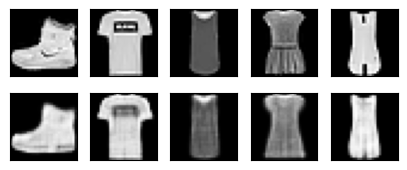

Train Error: 0.003214 

Validation Error: 0.003781 

Epoch 144
-------------------------------


782it [00:20, 37.49it/s]


[Epoch 143]


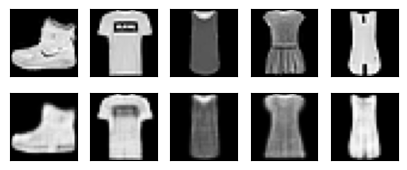

Train Error: 0.003204 

Validation Error: 0.003773 

Epoch 145
-------------------------------


782it [00:20, 38.38it/s]


[Epoch 144]


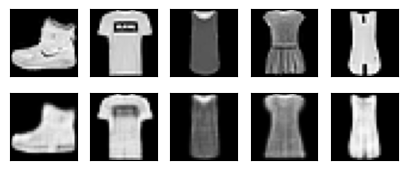

Train Error: 0.003204 

Validation Error: 0.003773 

Epoch 146
-------------------------------


782it [00:21, 37.19it/s]


[Epoch 145]


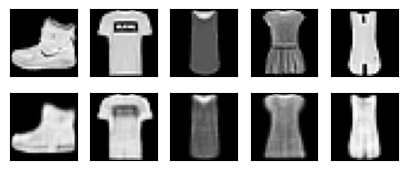

Train Error: 0.003196 

Validation Error: 0.003768 

Epoch 147
-------------------------------


782it [00:19, 39.45it/s]


[Epoch 146]


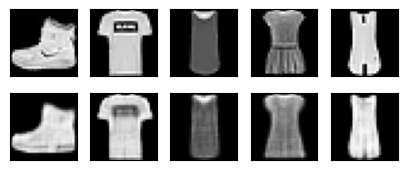

Train Error: 0.003184 

Validation Error: 0.003759 

Epoch 148
-------------------------------


782it [00:20, 37.70it/s]


[Epoch 147]


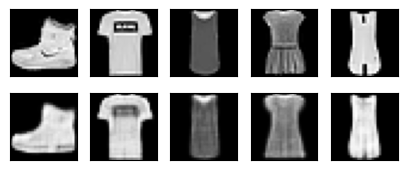

Train Error: 0.003170 

Validation Error: 0.003748 

Epoch 149
-------------------------------


782it [00:20, 37.84it/s]


[Epoch 148]


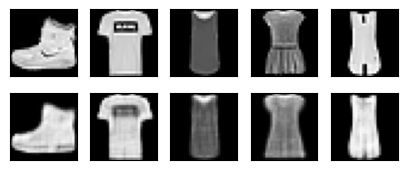

Train Error: 0.003174 

Validation Error: 0.003753 

Epoch 150
-------------------------------


782it [00:21, 36.29it/s]


[Epoch 149]


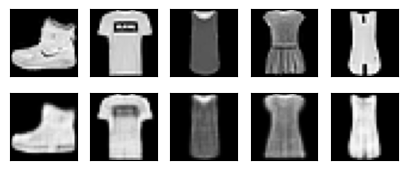

Train Error: 0.003164 

Validation Error: 0.003746 

Epoch 151
-------------------------------


782it [00:20, 38.32it/s]


[Epoch 150]


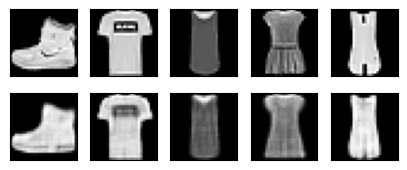

Train Error: 0.003176 

Validation Error: 0.003758 

Epoch 152
-------------------------------


782it [00:20, 37.67it/s]


[Epoch 151]


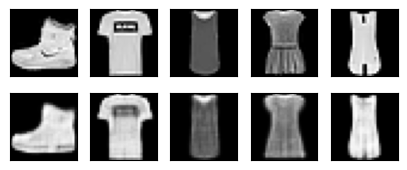

Train Error: 0.003164 

Validation Error: 0.003749 

Epoch 153
-------------------------------


782it [00:20, 38.59it/s]


[Epoch 152]


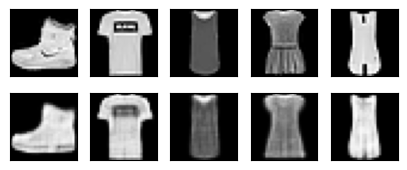

Train Error: 0.003169 

Validation Error: 0.003755 

Epoch 154
-------------------------------


782it [00:20, 37.62it/s]


[Epoch 153]


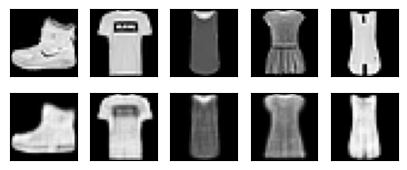

Train Error: 0.003160 

Validation Error: 0.003749 

Epoch 155
-------------------------------


782it [00:20, 38.02it/s]


[Epoch 154]


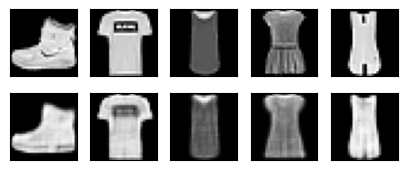

Train Error: 0.003160 

Validation Error: 0.003750 

Epoch 156
-------------------------------


782it [00:21, 37.00it/s]


[Epoch 155]


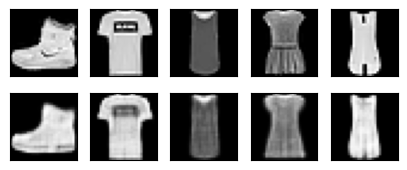

Train Error: 0.003152 

Validation Error: 0.003746 

Epoch 157
-------------------------------


782it [00:20, 38.25it/s]


[Epoch 156]


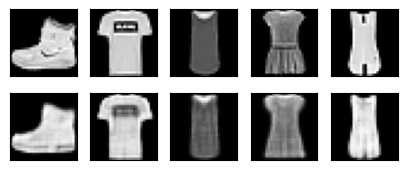

Train Error: 0.003175 

Validation Error: 0.003768 

Epoch 158
-------------------------------


782it [00:20, 37.88it/s]


[Epoch 157]


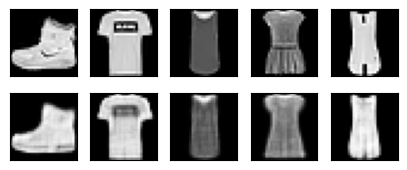

Train Error: 0.003158 

Validation Error: 0.003754 

Epoch 159
-------------------------------


782it [00:20, 37.97it/s]


[Epoch 158]


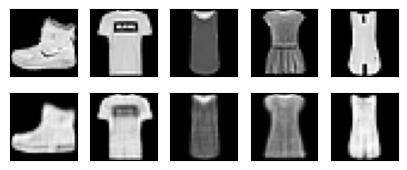

Train Error: 0.003175 

Validation Error: 0.003771 

Epoch 160
-------------------------------


782it [00:21, 36.91it/s]


[Epoch 159]


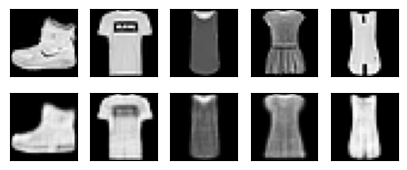

Train Error: 0.003188 

Validation Error: 0.003787 

Epoch 161
-------------------------------


782it [00:20, 38.18it/s]


[Epoch 160]


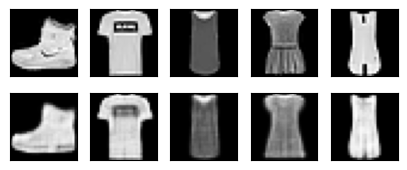

Train Error: 0.003177 

Validation Error: 0.003776 

Epoch 162
-------------------------------


782it [00:20, 38.38it/s]


[Epoch 161]


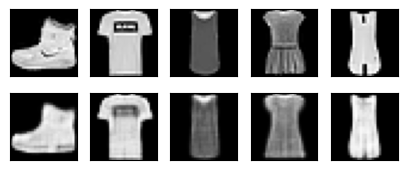

Train Error: 0.003178 

Validation Error: 0.003778 

Epoch 163
-------------------------------


782it [00:21, 37.06it/s]


[Epoch 162]


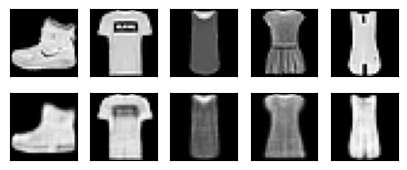

Train Error: 0.003188 

Validation Error: 0.003788 

Epoch 164
-------------------------------


782it [00:20, 37.99it/s]


[Epoch 163]


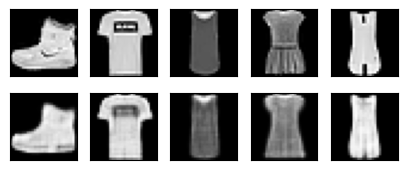

Train Error: 0.003182 

Validation Error: 0.003785 

Epoch 165
-------------------------------


782it [00:21, 37.05it/s]


[Epoch 164]


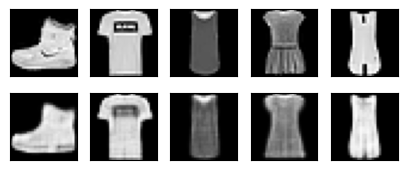

Train Error: 0.003187 

Validation Error: 0.003790 

Epoch 166
-------------------------------


782it [00:20, 37.81it/s]


[Epoch 165]


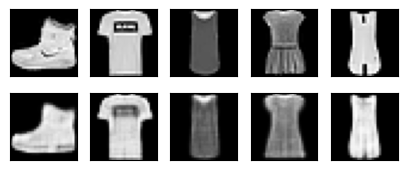

Train Error: 0.003162 

Validation Error: 0.003768 

Epoch 167
-------------------------------


782it [00:20, 38.37it/s]


[Epoch 166]


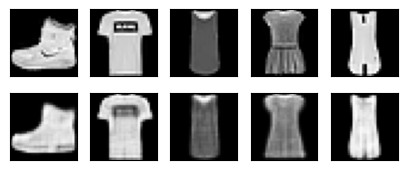

Train Error: 0.003147 

Validation Error: 0.003755 

Epoch 168
-------------------------------


782it [00:21, 37.00it/s]


[Epoch 167]


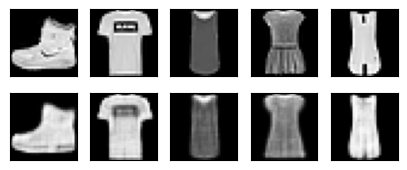

Train Error: 0.003132 

Validation Error: 0.003744 

Epoch 169
-------------------------------


782it [00:21, 37.12it/s]


[Epoch 168]


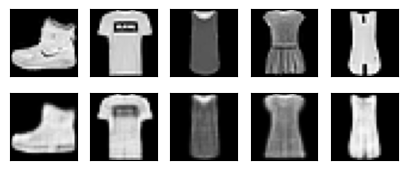

Train Error: 0.003133 

Validation Error: 0.003745 

Epoch 170
-------------------------------


782it [00:20, 37.89it/s]


[Epoch 169]


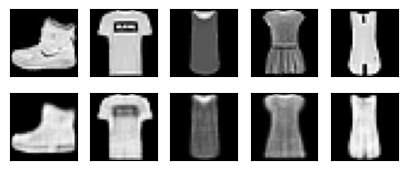

Train Error: 0.003122 

Validation Error: 0.003739 

Epoch 171
-------------------------------


782it [00:20, 38.16it/s]


[Epoch 170]


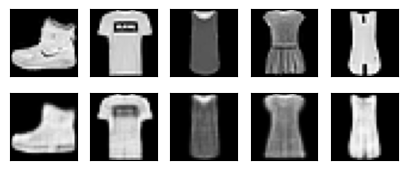

Train Error: 0.003128 

Validation Error: 0.003744 

Epoch 172
-------------------------------


782it [00:21, 37.00it/s]


[Epoch 171]


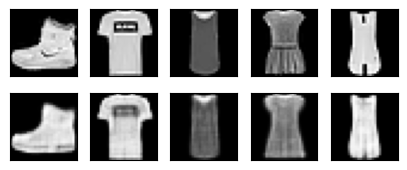

Train Error: 0.003119 

Validation Error: 0.003741 

Epoch 173
-------------------------------


782it [00:20, 37.31it/s]


[Epoch 172]


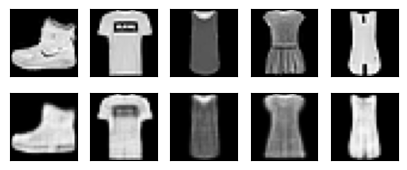

Train Error: 0.003129 

Validation Error: 0.003749 

Epoch 174
-------------------------------


782it [00:20, 38.38it/s]


[Epoch 173]


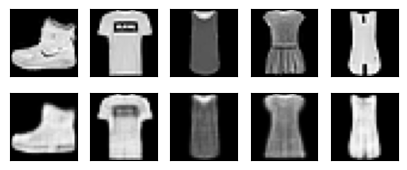

Train Error: 0.003114 

Validation Error: 0.003738 

Epoch 175
-------------------------------


782it [00:21, 36.45it/s]


[Epoch 174]


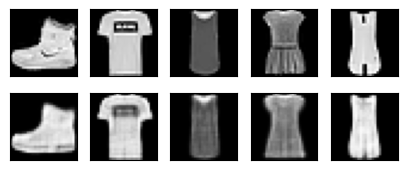

Train Error: 0.003120 

Validation Error: 0.003743 

Epoch 176
-------------------------------


782it [00:21, 36.78it/s]


[Epoch 175]


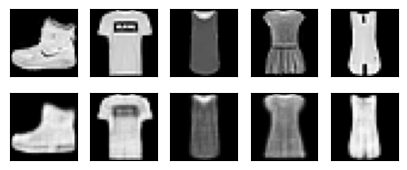

Train Error: 0.003112 

Validation Error: 0.003740 

Epoch 177
-------------------------------


782it [00:20, 37.28it/s]


[Epoch 176]


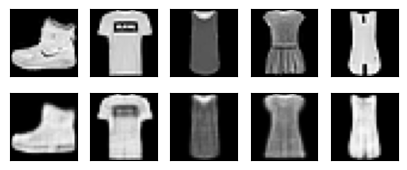

Train Error: 0.003124 

Validation Error: 0.003752 

Epoch 178
-------------------------------


782it [00:20, 37.33it/s]


[Epoch 177]


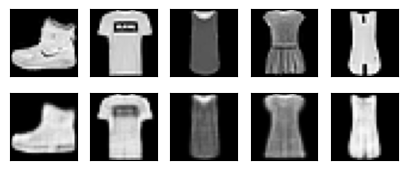

Train Error: 0.003119 

Validation Error: 0.003749 

Epoch 179
-------------------------------


782it [00:20, 37.27it/s]


[Epoch 178]


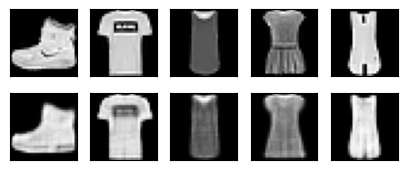

Train Error: 0.003132 

Validation Error: 0.003761 

Epoch 180
-------------------------------


782it [00:21, 36.82it/s]


[Epoch 179]


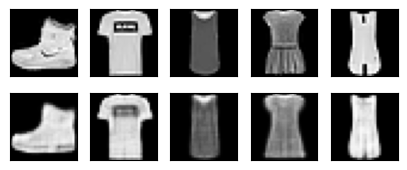

Train Error: 0.003138 

Validation Error: 0.003771 

Epoch 181
-------------------------------


782it [00:20, 37.41it/s]


[Epoch 180]


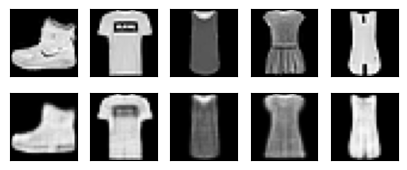

Train Error: 0.003140 

Validation Error: 0.003772 

Epoch 182
-------------------------------


782it [00:20, 37.90it/s]


[Epoch 181]


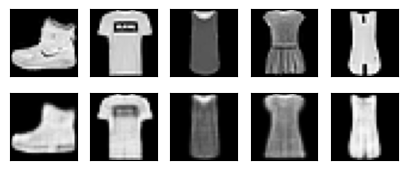

Train Error: 0.003141 

Validation Error: 0.003776 

Epoch 183
-------------------------------


782it [00:21, 36.84it/s]


[Epoch 182]


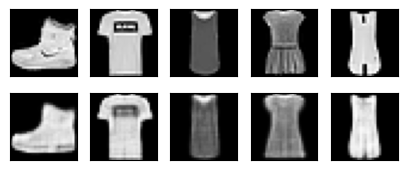

Train Error: 0.003133 

Validation Error: 0.003771 

Epoch 184
-------------------------------


782it [00:21, 36.68it/s]


[Epoch 183]


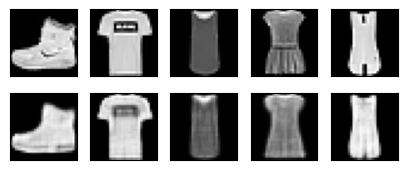

Train Error: 0.003121 

Validation Error: 0.003761 

Epoch 185
-------------------------------


782it [00:20, 38.17it/s]


[Epoch 184]


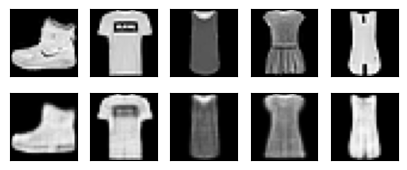

Train Error: 0.003122 

Validation Error: 0.003762 

Epoch 186
-------------------------------


782it [00:21, 36.04it/s]


[Epoch 185]


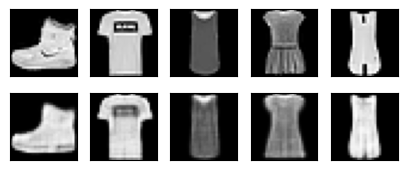

Train Error: 0.003105 

Validation Error: 0.003751 

Epoch 187
-------------------------------


782it [00:20, 37.24it/s]


[Epoch 186]


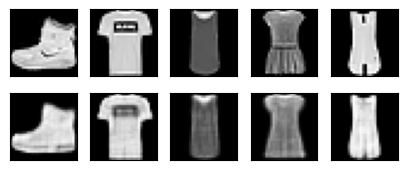

Train Error: 0.003107 

Validation Error: 0.003751 

Epoch 188
-------------------------------


782it [00:21, 36.96it/s]


[Epoch 187]


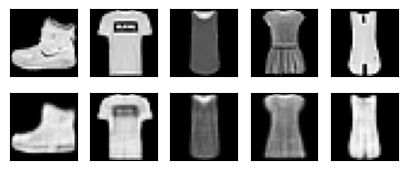

Train Error: 0.003091 

Validation Error: 0.003739 

Epoch 189
-------------------------------


782it [00:20, 37.64it/s]


[Epoch 188]


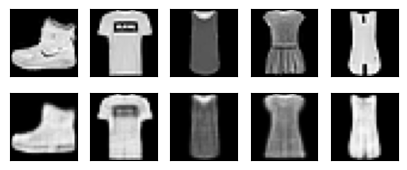

Train Error: 0.003100 

Validation Error: 0.003747 

Epoch 190
-------------------------------


782it [00:21, 35.61it/s]


[Epoch 189]


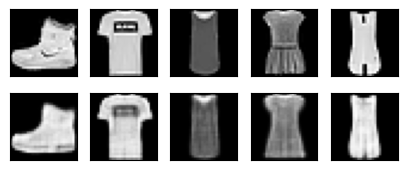

Train Error: 0.003089 

Validation Error: 0.003740 

Epoch 191
-------------------------------


782it [00:20, 37.52it/s]


[Epoch 190]


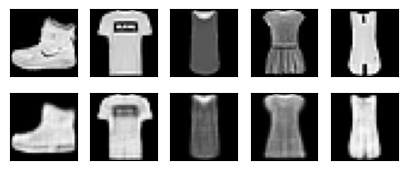

Train Error: 0.003084 

Validation Error: 0.003736 

Epoch 192
-------------------------------


782it [00:20, 37.70it/s]


[Epoch 191]


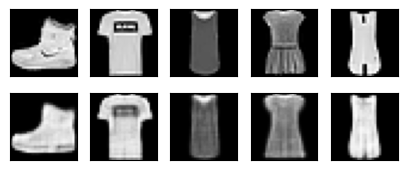

Train Error: 0.003088 

Validation Error: 0.003742 

Epoch 193
-------------------------------


782it [00:20, 37.63it/s]


[Epoch 192]


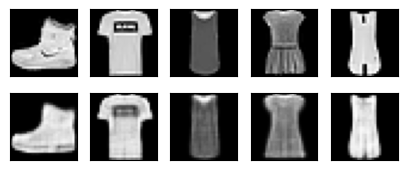

Train Error: 0.003086 

Validation Error: 0.003741 

Epoch 194
-------------------------------


782it [00:21, 37.01it/s]


[Epoch 193]


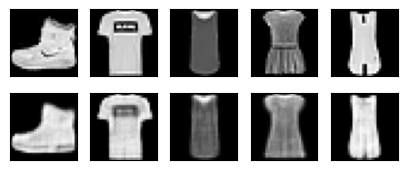

Train Error: 0.003087 

Validation Error: 0.003744 

Epoch 195
-------------------------------


782it [00:20, 37.88it/s]


[Epoch 194]


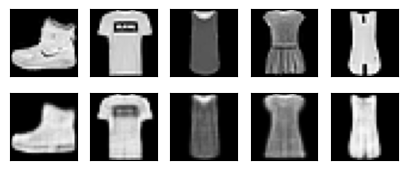

Train Error: 0.003110 

Validation Error: 0.003768 

Epoch 196
-------------------------------


782it [00:20, 37.79it/s]


[Epoch 195]


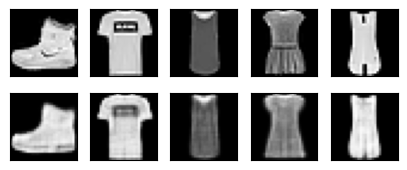

Train Error: 0.003101 

Validation Error: 0.003759 

Epoch 197
-------------------------------


782it [00:20, 38.43it/s]


[Epoch 196]


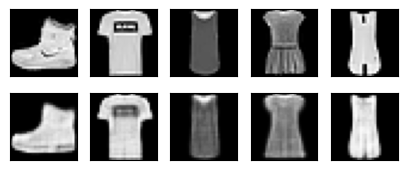

Train Error: 0.003112 

Validation Error: 0.003773 

Epoch 198
-------------------------------


782it [00:21, 37.19it/s]


[Epoch 197]


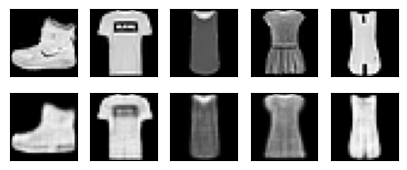

Train Error: 0.003139 

Validation Error: 0.003797 

Epoch 199
-------------------------------


782it [00:20, 37.50it/s]


[Epoch 198]


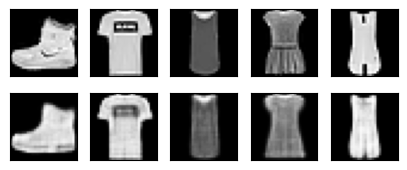

Train Error: 0.003168 

Validation Error: 0.003827 

Epoch 200
-------------------------------


782it [00:20, 37.48it/s]


[Epoch 199]


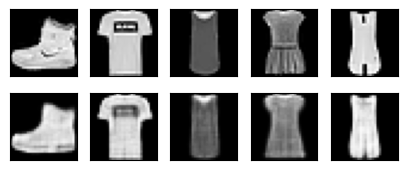

Train Error: 0.003195 

Validation Error: 0.003851 

Done!


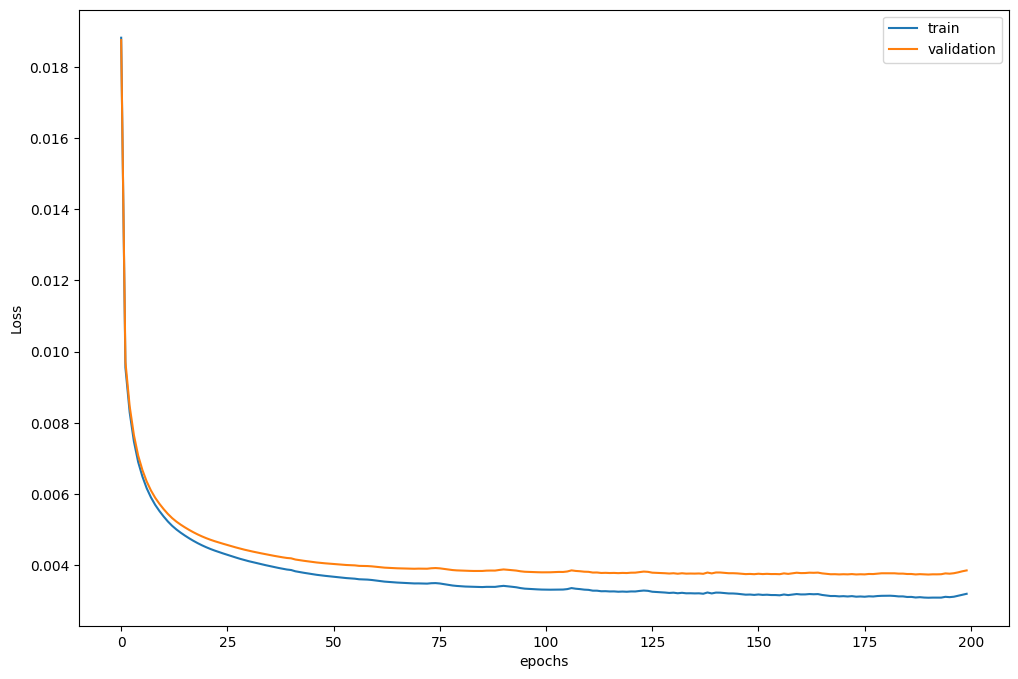

In [9]:
# 학습을 진행합니다.
train_loss_list = []

val_loss_list = []

for t in range((EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    train_loss = test(train_dataloader, model, loss_fn)

    f, a = plt.subplots(2,5,figsize=(5,2))
    print("[Epoch {}]".format(t))
    for i in range(5):
      img = np.reshape(view_data.data.numpy()[i],(28,28))
      a[0][i].imshow(img, cmap="gray")
      a[0][i].set_xticks(())
      a[0][i].set_yticks(())

    for i in range(5):
      recon = model(view_data.to(device))
      img = np.reshape(recon.data.numpy()[i],(28,28))
      a[1][i].imshow(img, cmap="gray")
      a[1][i].set_xticks(())
      a[1][i].set_yticks(())
    plt.show()

    print(f"Train Error: {train_loss:>8f} \n")
    train_loss_list.append(train_loss)

    val_loss = test(validation_dataloader, model, loss_fn)
    print(f"Validation Error: {val_loss:>8f} \n")
    val_loss_list.append(val_loss)

print("Done!")

plt.figure(figsize=(12,8))

plt.plot(train_loss_list,label="train")
plt.plot(val_loss_list,label="validation")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [10]:
test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: {test_loss:>8f} \n")


Test Error: 0.003817 



# Task 1: Denoising

In [11]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.3
  noisy_img = img + noise
  return noisy_img

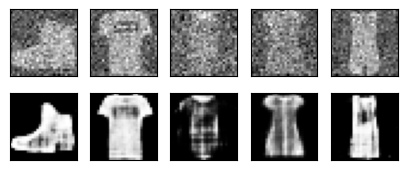

In [12]:
f, a = plt.subplots(2,5,figsize=(5,2))

for i in range(5):
  noisy_data = add_noise(view_data)
  img = np.reshape(noisy_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(noisy_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()

# Task 2: Anomaly detection

In [13]:
def anomaly_detection(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = []

    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X = X.view(-1,28*28).to(device)

            recon = model(X)
            loss = loss_fn(recon, X)
            test_loss.append(loss)
    return test_loss

In [14]:
# 학습때 경험하지 못한 MNIST 데이터를 비정상 데이터로 활용하여, anomaly detection을 진행합니다.
# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
abnor_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

abnor_dataloader = DataLoader(abnor_data, batch_size=len(test_data))

view_abnor_data = abnor_data.data[:5].view(-1,28*28)
view_abnor_data = view_abnor_data.type(torch.FloatTensor)/255.

100%|██████████| 9912422/9912422 [00:00<00:00, 65855001.48it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20760187.46it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 18863305.43it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5627925.78it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [15]:
normal_score = anomaly_detection(test_dataloader, model, loss_fn)
abnormal_score = anomaly_detection(abnor_dataloader, model, loss_fn)

In [16]:
len(test_data)

10000

In [17]:
len(abnor_data)

10000

Text(0, 0.5, 'count')

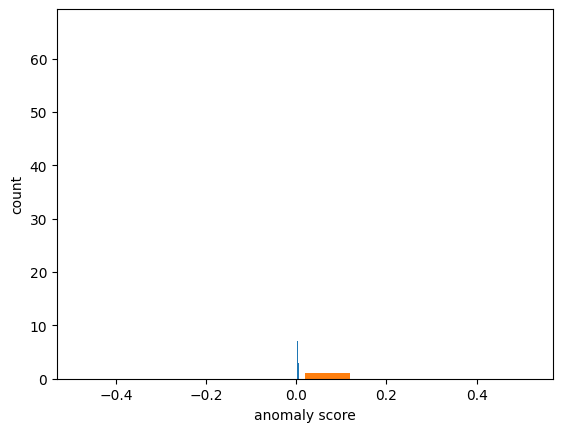

In [18]:
bins_list = []
for i in range(200):
  bins_list.append(i*0.002)
plt.hist(normal_score)
plt.hist(abnormal_score)

plt.xlabel("anomaly score")
plt.ylabel("count")

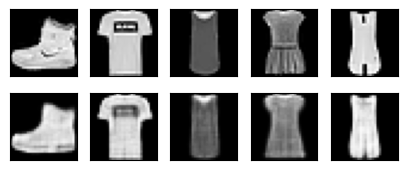

In [19]:
f, a = plt.subplots(2,5,figsize=(5,2))


for i in range(5):
  img = np.reshape(view_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(view_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()

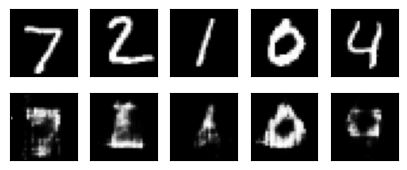

In [20]:
f, a = plt.subplots(2,5,figsize=(5,2))


for i in range(5):
  img = np.reshape(view_abnor_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(view_abnor_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()